In [ ]:
import itertools as it
import networkx as nx
import matplotlib.pyplot as plt
import re
from pprint import pprint
from collections import Counter


In [2]:
# Read the SQL DDLs
DDL_file = "./test_parser.sql"
with open(DDL_file) as fp:
    ddl = fp.read()

In [3]:
def parse_ddl(ddl: str):
    """
    Parses SQL DDL statements and extracts table names, columns, primary keys, and foreign keys.

    :param ddl: DDL string containing table definitions.
    :return: A list of dictionaries with keys: table_name, columns, primary_keys, foreign_keys.
    """
    tables_info = []

    # Split the DDL into individual CREATE TABLE statements
    table_statements = re.split(r"CREATE TABLE", ddl, flags=re.IGNORECASE)[1:]

    for statement in table_statements:
        # Extract table name
        table_name_match = re.search(r"`(\w+)`", statement)
        if not table_name_match:
            continue
        table_name = table_name_match.group(0)  # Include backticks in table name

        # Remove the CREATE TABLE `tablename` part from the statement
        statement = re.sub(r"^\s*`\w+`\s*\(", "", statement, count=1)

        # Split statement into lines and filter out non-column definitions
        lines = statement.splitlines()
        column_lines = []
        for line in lines:
            line = line.strip()
            if line.startswith("PRIMARY KEY") or line.startswith("KEY") or line.startswith("CONSTRAINT") or line.startswith("FOREIGN KEY"):
                continue
            if line.endswith(","):
                line = line[:-1]
            column_lines.append(line)
        
        # Extract column definitions
        column_pattern = r"(`\w+`)\s+([^,]+)"
        columns = []
        for column_line in column_lines:
            column_match = re.match(column_pattern, column_line)
            if column_match:
                column_name = column_match.group(1)  # Include backticks in column name
                column_definition = column_match.group(2).strip()
                columns.append({
                    "name": column_name,
                    "definition": column_definition
                })

        # Extract primary key
        primary_key_match = re.search(r"PRIMARY KEY \(([`\w`, ]+)\)", statement)
        primary_keys = [key.strip() for key in primary_key_match.group(1).split(",")] if primary_key_match else []

        # Extract foreign keys
        fk_pattern = r"FOREIGN KEY \(([`\w`, ]+)\) REFERENCES ([`\w`]+) \(([`\w`, ]+)\)(?: ON DELETE (\w+))?"
        foreign_keys = []
        for fk_match in re.findall(fk_pattern, statement):
            from_columns = [col.strip() for col in fk_match[0].split(",")]
            referenced_table = fk_match[1]
            referenced_columns = [col.strip() for col in fk_match[2].split(",")]
            on_delete = fk_match[3] if fk_match[3] else "NO ACTION"

            foreign_keys.append({
                "columns": from_columns,
                "referenced_table": referenced_table,
                "referenced_columns": referenced_columns,
                "on_delete": on_delete
            })

        # Store table information
        tables_info.append({
            "table_name": table_name,
            "columns": columns,
            "primary_keys": primary_keys,
            "foreign_keys": foreign_keys
        })

    return tables_info

results = parse_ddl(ddl)
print(f"#Tables: {len(results)}")
pprint(results)

#Tables: 11
[{'columns': [{'definition': 'varchar(5) NOT NULL', 'name': '`s_ID`'},
              {'definition': 'varchar(5) DEFAULT NULL', 'name': '`i_ID`'},
              {'definition': "datetime NOT NULL DEFAULT '2009-04-30 08:30:00'",
               'name': '`timestamp`'}],
  'foreign_keys': [{'columns': ['`i_ID`'],
                    'on_delete': 'SET',
                    'referenced_columns': ['`ID`'],
                    'referenced_table': '`instructor`'},
                   {'columns': ['`s_ID`'],
                    'on_delete': 'CASCADE',
                    'referenced_columns': ['`ID`'],
                    'referenced_table': '`student`'}],
  'primary_keys': ['`s_ID`'],
  'table_name': '`advisor`'},
 {'columns': [{'definition': 'varchar(15) NOT NULL', 'name': '`building`'},
              {'definition': 'varchar(7) NOT NULL', 'name': '`room_number`'},
              {'definition': 'decimal(4', 'name': '`capacity`'}],
  'foreign_keys': [],
  'primary_keys': ['`building`', '

In [4]:

def get_multidigraph(results:list) -> nx.multidigraph:
    # Create a directed graph
    graph = nx.MultiDiGraph()

    # Add nodes (tables)
    tables = [result["table_name"] for result in results]
    # graph.add_nodes_from(tables)
    for result in results:
        graph.add_node(result["table_name"], total_columns = len(result["columns"]))

    # Add Edges (the referenced table of the foreign key is the sink of the edge)
    for result in results:
        if len(result['foreign_keys']) > 0:
            for foreign_key in result['foreign_keys']:
                edge_weight = 1
                for referenced_column in zip(foreign_key["columns"], foreign_key["referenced_columns"]):
                    # graph.add_edge(result['table_name'], foreign_key['referenced_table'],
                    #                relation=referenced_column)
                    relation_key = f"{referenced_column[0]}->{referenced_column[1]}"
                    # relation_key =  referenced_column
                    graph.add_edge(result['table_name'], foreign_key['referenced_table'],
                                key=relation_key, relation=relation_key, weight = edge_weight)
                    # edge_weight += 1

    return graph

def get_simple_digraph(graph:nx.multidigraph) -> nx.digraph:
    c = Counter(graph.edges())
    simple_digraph = nx.DiGraph()
    simple_digraph.add_nodes_from(graph.nodes(data=True))

    for u, v, d in graph.edges(data=True):
        # avoid repeating edges and self-loops
        if not simple_digraph.has_edge(u, v) and u != v:
            weight = c[u, v]
            simple_digraph.add_edge(u, v, weight=weight)
            # simple_digraph.add_edge(u, v, weight=1)


    # print(list(simple_digraph.edges(data=True)))
    return simple_digraph

def get_unweighted_simple_digraph(graph:nx.multidigraph) -> nx.digraph:
    c = Counter(graph.edges())
    simple_digraph = nx.DiGraph()
    simple_digraph.add_nodes_from(graph.nodes(data=True))

    for u, v, d in graph.edges(data=True):
        # avoid repeating edges and self-loops
        if not simple_digraph.has_edge(u, v) and u != v:
            weight = 1
            simple_digraph.add_edge(u, v, weight=weight)
            # simple_digraph.add_edge(u, v, weight=1)


    # print(list(simple_digraph.edges(data=True)))
    return simple_digraph

graph = get_multidigraph(results)
simple_graph = get_simple_digraph(graph)

print(graph.edges(data=True))
print(simple_graph.edges(data=True))

[('`advisor`', '`instructor`', {'relation': '`i_ID`->`ID`', 'weight': 1}), ('`advisor`', '`student`', {'relation': '`s_ID`->`ID`', 'weight': 1}), ('`course`', '`department`', {'relation': '`dept_name`->`dept_name`', 'weight': 1}), ('`instructor`', '`department`', {'relation': '`dept_name`->`dept_name`', 'weight': 1}), ('`prereq`', '`course`', {'relation': '`course_id`->`course_id`', 'weight': 1}), ('`prereq`', '`course`', {'relation': '`prereq_id`->`course_id`', 'weight': 1}), ('`section`', '`course`', {'relation': '`course_id`->`course_id`', 'weight': 1}), ('`section`', '`classroom`', {'relation': '`building`->`building`', 'weight': 1}), ('`section`', '`classroom`', {'relation': '`room_number`->`room_number`', 'weight': 1}), ('`section`', '`time_slot`', {'relation': '`time_slot_id`->`time_slot_id`', 'weight': 1}), ('`student`', '`department`', {'relation': '`dept_name`->`dept_name`', 'weight': 1}), ('`takes`', '`section`', {'relation': '`course_id`->`course_id`', 'weight': 1}), ('`tak

In [5]:
import matplotlib


def draw_colored_planar_graph(graph: nx.MultiDiGraph, communities:list):
    print(f"There are {len(communities)} communities")
    print(communities)
    
    fig, ax = plt.subplots(1, 1)

    fig.tight_layout()
    fig.set_size_inches(8, 8)
    node_size = 800

    if type(graph) == nx.MultiDiGraph:
        simple_digraph = get_simple_digraph(graph)
    else:
        simple_digraph = graph

    nodes = simple_digraph.nodes()

    cmap = matplotlib.colormaps["Pastel1"]  # type: matplotlib.colors.ListedColormap
    colors = cmap.colors

    # colors = ["pink", "lightgreen", "lightblue", "red", "green", "blue"]
    node_colors_dict = {}
    for entry in zip(colors[:len(communities)], communities):
        for node in entry[1]:
            node_colors_dict[node] = entry[0]
    print(node_colors_dict)
    node_colors = [node_colors_dict[node] for node in nodes]

    pos = nx.planar_layout(simple_digraph)
    nx.draw(simple_digraph, pos, with_labels=True, node_size=node_size,
            node_color=node_colors, font_size=8, 
            arrowsize=15, 
            ax=ax)
    edge_labels = nx.get_edge_attributes(simple_digraph, "weight")
    # print(type(edge_labels))
    # print(edge_labels)
    for edge in edge_labels.keys():
        edge_labels[edge] = f"{edge_labels[edge]:.2f}"

    nx.draw_networkx_edge_labels(simple_digraph, pos, 
                                 edge_labels=edge_labels, font_size=10, ax=ax)
    ax.set_title("DiGraph Weighted Edges Representation")
    plt.show()



There are 3 communities
[{'`course`', '`prereq`'}, {'`takes`', '`section`', '`teaches`'}, {'`student`', '`instructor`', '`advisor`', '`department`'}]
{'`course`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`prereq`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`takes`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`section`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`teaches`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`student`': (0.8, 0.9215686274509803, 0.7725490196078432), '`instructor`': (0.8, 0.9215686274509803, 0.7725490196078432), '`advisor`': (0.8, 0.9215686274509803, 0.7725490196078432), '`department`': (0.8, 0.9215686274509803, 0.7725490196078432)}


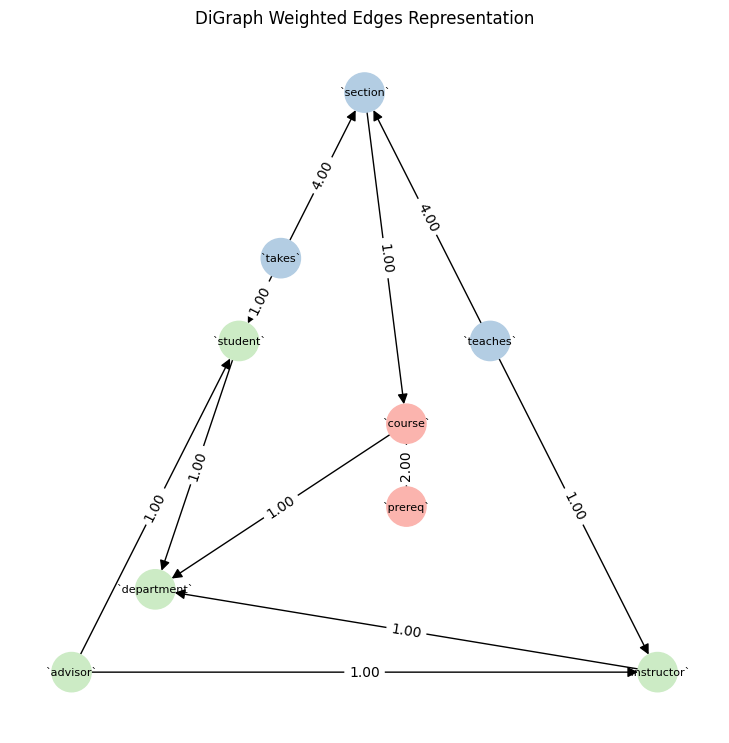

In [6]:
simple_graph = simple_graph.subgraph(simple_graph.nodes() - ["`time_slot`", "`classroom`"])
communities = nx.community.louvain_communities(simple_graph, seed = 0)
draw_colored_planar_graph(simple_graph, communities)

In [7]:
def update_weights_on_relations(graph:nx.DiGraph):
    updated_graph = nx.DiGraph()
    updated_graph.add_nodes_from(graph.nodes(data=True))

    for u, v, d in graph.edges(data=True):
        # avoid repeating edges and self-loops
        if not updated_graph.has_edge(u, v) and u != v:
            weight = d["weight"]
            if is_relation(u, graph):
                weight *= 1
            elif is_data_entity(v, graph) and not is_relation(u, graph):
                weight *= 1
            else:
                weight *= 1
            updated_graph.add_edge(u, v, weight=weight)

            # updated_graph.add_edge(u, v, weight=c[u, v])
    return updated_graph

def re_weights_on_edges(graph:nx.DiGraph):
    updated_graph = nx.DiGraph()
    updated_graph.add_nodes_from(graph.nodes(data=True))

    for u, v, d in graph.edges(data=True):
        # avoid repeating edges and self-loops
        if not updated_graph.has_edge(u, v) and u != v:
            weight = d["weight"]/graph.nodes[u]["total_columns"]
            updated_graph.add_edge(u, v, weight=weight)

            # updated_graph.add_edge(u, v, weight=c[u, v])
    return updated_graph

def add_self_edge_weight(graph:nx.DiGraph):
    nodes = graph.nodes()
    for node in nodes:
        outgoing_edges = graph.out_edges(node, data=True)
        total_outgoing_weight = sum(data.get('weight', 1) for _, _, data in outgoing_edges)
        self_loop_weight = 1 - total_outgoing_weight
        if self_loop_weight > 0:
            graph.add_edge(node, node, weight=self_loop_weight)
    return graph

def is_relation(node, graph:nx.DiGraph):
    if graph.has_node(node) and graph.in_degree(node) == 0:
        return True
    return False

def is_data_entity(node, graph:nx.DiGraph):
    if graph.has_node(node) and graph.out_degree(node) == 0:
        return True
    return False

# print(simple_graph.edges(data=True))
updated_graph = re_weights_on_edges(simple_graph)
# updated_graph = add_self_edge_weight(updated_graph)
# updated_graph = update_weights_on_relations(unweighted_graph)
print(updated_graph.nodes(data=True))
print(updated_graph.edges(data=True))




[('`advisor`', {'total_columns': 3}), ('`course`', {'total_columns': 4}), ('`department`', {'total_columns': 3}), ('`instructor`', {'total_columns': 4}), ('`prereq`', {'total_columns': 2}), ('`section`', {'total_columns': 7}), ('`student`', {'total_columns': 5}), ('`takes`', {'total_columns': 7}), ('`teaches`', {'total_columns': 5})]
[('`advisor`', '`instructor`', {'weight': 0.3333333333333333}), ('`advisor`', '`student`', {'weight': 0.3333333333333333}), ('`course`', '`department`', {'weight': 0.25}), ('`instructor`', '`department`', {'weight': 0.25}), ('`prereq`', '`course`', {'weight': 1.0}), ('`section`', '`course`', {'weight': 0.14285714285714285}), ('`student`', '`department`', {'weight': 0.2}), ('`takes`', '`section`', {'weight': 0.5714285714285714}), ('`takes`', '`student`', {'weight': 0.14285714285714285}), ('`teaches`', '`section`', {'weight': 0.8}), ('`teaches`', '`instructor`', {'weight': 0.2})]


There are 3 communities
[{'`course`', '`prereq`'}, {'`student`', '`instructor`', '`advisor`', '`department`'}, {'`takes`', '`section`', '`teaches`'}]
{'`course`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`prereq`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`student`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`instructor`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`advisor`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`department`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`takes`': (0.8, 0.9215686274509803, 0.7725490196078432), '`section`': (0.8, 0.9215686274509803, 0.7725490196078432), '`teaches`': (0.8, 0.9215686274509803, 0.7725490196078432)}


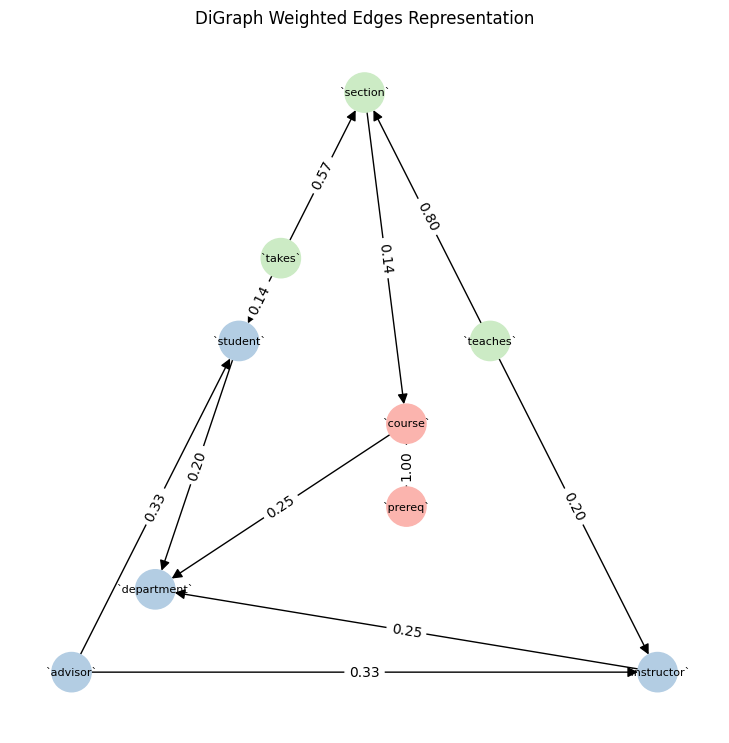

In [8]:
communities = nx.community.louvain_communities(updated_graph, resolution=0.7)
draw_colored_planar_graph(updated_graph, communities)

({'`student`', '`instructor`', '`advisor`', '`department`'}, {'`course`', '`prereq`'}, {'`takes`', '`section`', '`teaches`'})
There are 3 communities
({'`student`', '`instructor`', '`advisor`', '`department`'}, {'`course`', '`prereq`'}, {'`takes`', '`section`', '`teaches`'})
{'`student`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`instructor`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`advisor`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`department`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`course`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`prereq`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`takes`': (0.8, 0.9215686274509803, 0.7725490196078432), '`section`': (0.8, 0.9215686274509803, 0.7725490196078432), '`teaches`': (0.8, 0.9215686274509803, 0.7725490196078432)}


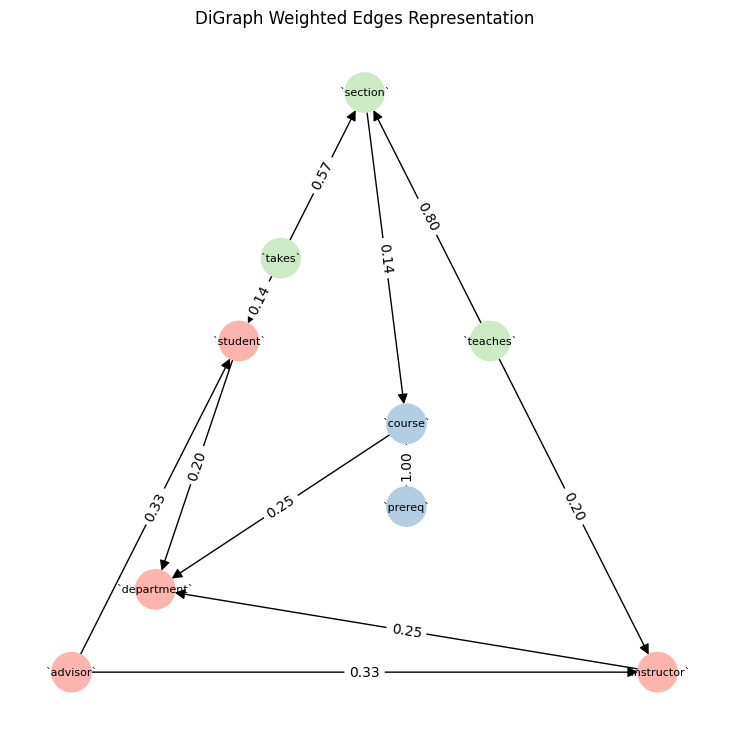

In [9]:
# communities = nx.community.louvain_communities(updated_graph, seed = 0)
# unweighted_graph = get_unweighted_simple_digraph(simple_graph)
# communities = nx.community.girvan_newman(unweighted_graph)
communities = nx.community.girvan_newman(updated_graph)

community_slice = list(communities)[1]
print(community_slice)
draw_colored_planar_graph(updated_graph, community_slice)

There are 3 communities
[frozenset({'`department`', '`instructor`', '`advisor`', '`student`'}), frozenset({'`takes`', '`section`', '`teaches`'}), frozenset({'`course`', '`prereq`'})]
{'`department`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`instructor`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`advisor`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`student`': (0.984313725490196, 0.7058823529411765, 0.6823529411764706), '`takes`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`section`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`teaches`': (0.7019607843137254, 0.803921568627451, 0.8901960784313725), '`course`': (0.8, 0.9215686274509803, 0.7725490196078432), '`prereq`': (0.8, 0.9215686274509803, 0.7725490196078432)}


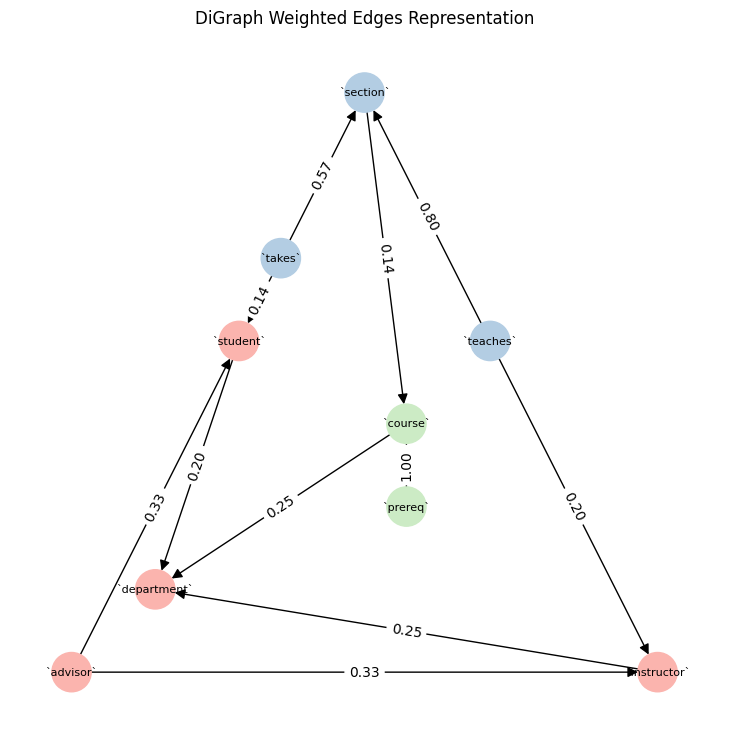

In [10]:
# unweighted_graph = get_unweighted_simple_digraph(simple_graph)

cm = list(nx.community.greedy_modularity_communities(updated_graph, weight="weight"))
# communities = nx.community.asyn_lpa_communities(updated_graph, weight="weight")
draw_colored_planar_graph(updated_graph, list(cm))

There are 3 communities
((0.7019607843137254, 0.8862745098039215, 0.803921568627451), (0.9921568627450981, 0.803921568627451, 0.6745098039215687), (0.796078431372549, 0.8352941176470589, 0.9098039215686274))


c:\Users\devas\anaconda3\envs\llm\lib\site-packages\networkx\drawing\nx_pylab.py:457: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


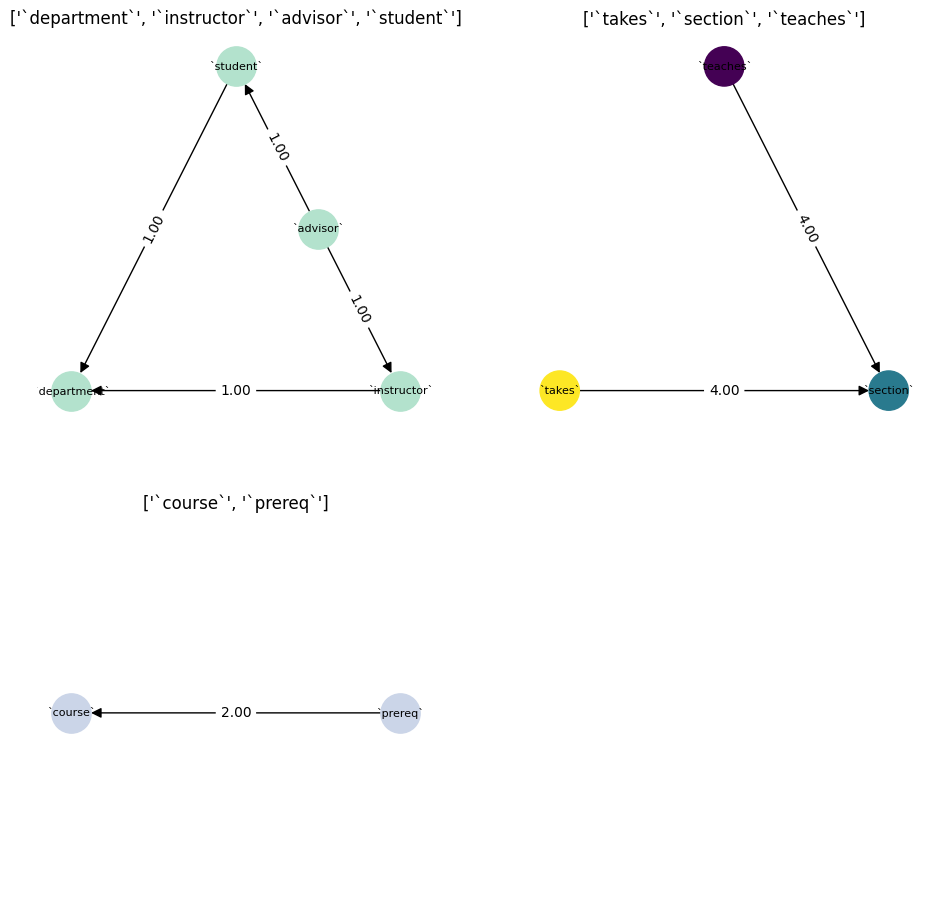

In [11]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib

def flatten(xss):
    return [x for xs in xss for x in xs]

def draw_communities(graph: nx.DiGraph, communities): 
    print(f"There are {len(communities)} communities")
    
    nrows = (len(communities) + 1) // 2  # Two plots per row
    fig, axs = plt.subplots(nrows, 2, squeeze=False)
    fig.tight_layout()
    fig.set_size_inches(10, 5 * nrows)
    node_size = 800

    if isinstance(graph, nx.MultiDiGraph):
        simple_digraph = nx.DiGraph(graph)  # Simplify to a directed graph
    else:
        simple_digraph = graph

    cmap = matplotlib.colormaps["Pastel2"]
    colors = cmap.colors
    colors = colors[:len(communities)]

    # Ensure axs is iterable
    axs = axs.flat
    print(colors)
    for ax, community, color in zip(axs, communities, colors):
        sub = simple_digraph.subgraph(community)
        pos = nx.planar_layout(sub)
        nx.draw(
            sub, pos, with_labels=True, node_size=node_size,
            node_color=color, font_size=8, arrowsize=15, ax=ax
        )
        edge_labels = nx.get_edge_attributes(sub, "weight")
        for edge in edge_labels.keys():
            edge_labels[edge] = f"{edge_labels[edge]:.2f}"

        nx.draw_networkx_edge_labels(sub, pos, edge_labels=edge_labels, font_size=10, ax=ax)
        ax.set_title(f"{[str(x) for x in list(community)]}")

    # Hide unused subplots
    for unused_ax in axs[len(communities):]:
        unused_ax.axis('off')

    plt.show()

# Example usage
# Replace 'simple_graph' with your graph and 'cm' with your communities

draw_communities(simple_graph, list(cm))

In [15]:
from cdlib import algorithms
print(simple_graph.edges())
coms = algorithms.lswl(simple_graph.copy())
print(coms.to_node_community_map())
print(coms.to_json())
print(coms.get_description())

[('`advisor`', '`instructor`'), ('`advisor`', '`student`'), ('`course`', '`department`'), ('`instructor`', '`department`'), ('`prereq`', '`course`'), ('`section`', '`course`'), ('`student`', '`department`'), ('`takes`', '`section`'), ('`takes`', '`student`'), ('`teaches`', '`section`'), ('`teaches`', '`instructor`')]


TypeError: lswl() missing 1 required positional argument: 'query_node'